# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# Set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

In [3]:
# make a directory for figures
!mkdir -p figs

In [4]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [5]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [6]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [7]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [8]:
lattice = make_ring_lattice(10, 4)

Saving figure to file figs/chap03-1


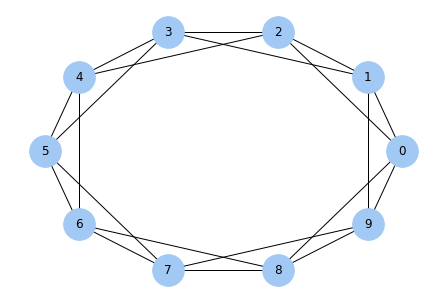

In [9]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

Saving figure to file figs/chap03-1


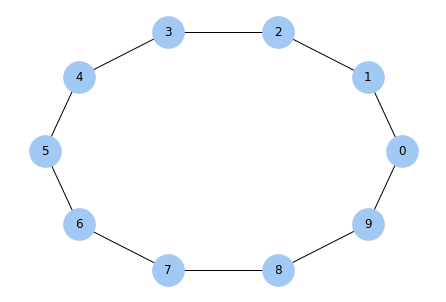

In [10]:
# Solution goes here

lattice = make_ring_lattice(10, 3)

nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

Saving figure to file figs/chap03-1


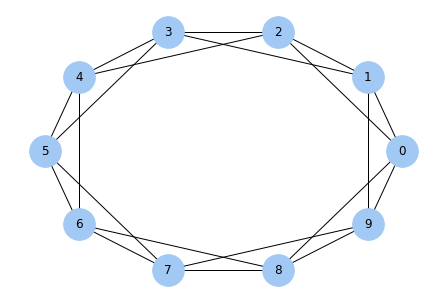

In [11]:
# Solution goes here

lattice = make_ring_lattice(10, 5)

nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

One of the exercises below asks you to explore regular graphs with odd values of `k`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [12]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

To do the rewiring, we'll need `flip`.

In [13]:
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's the function that does the rewiring

In [87]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    # Fill this in

In [15]:
# Solution

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)

Here's an example with `p=0.2`

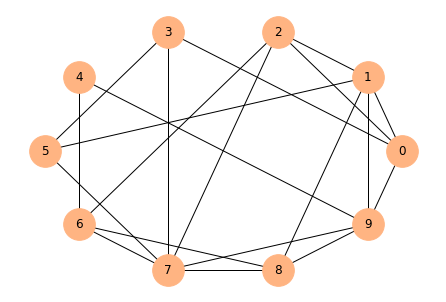

In [16]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [17]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

Saving figure to file figs/chap03-2


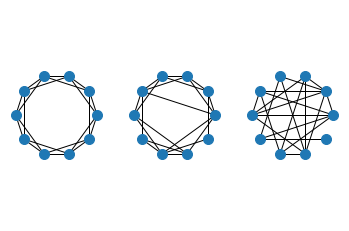

In [18]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

savefig('figs/chap03-2')

**Exercise:** What is the order of growth of `rewire`?

In [13]:
# Solution

"""The loop executes once for each edge.  Inside the loop, everything is constant
time except computing `choices`, which is linear in `n`.  So the total run time is 
`O(nm)`.""";

# I think with some memoization / optimization, "choices = nodes - {u} - set(G[u])" can be O(1)

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [19]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

In [20]:
def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [21]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    # FILL THIS IN
    return 0

In [22]:
# Solution goes here

def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    # FILL THIS IN
    return np.nanmean([node_clustering(G, node) for node in G])

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [23]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [24]:
clustering_coefficient(lattice)

0.5

Correct.

In [25]:
%timeit clustering_coefficient(lattice)

37.8 µs ± 558 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [26]:
# # Solution goes here

# def node_clustering(G, u):
#     """Computes local clustering coefficient for `u`.
    
#     G: Graph
#     u: node
    
#     returns: float
#     """
#     neighbors = G[u]
#     k = len(neighbors)
#     if k < 2:
#         return np.nan
        
#     possible = k * (k-1) / 2
#     exist = 0    
#     for v, w in all_pairs(neighbors):
#         if G.has_edge(v, w):
#             exist +=1
#     return exist / possible

# Solution

def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.mean(edges)

clustering_coefficient(lattice)

0.5

In [27]:
%timeit clustering_coefficient(lattice)

78.8 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [21]:
# Solution goes here

# O(n * k^2)

## Path length

The following function computes path lengths between all pairs of nodes

In [91]:
def path_lengths(G):
    # FILL THIS IN
    yield 0

In [35]:
# Solution

def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        # print(source, dist_map)
        for dest, dist in dist_map.items():
            if source != dest:
                yield dist

The characteristic path length is the mean path length for all pairs.

In [36]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [37]:
complete = nx.complete_graph(3)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [38]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [39]:
# Solution goes here

lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [40]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [41]:
%time run_one_graph(1000, 10, 0.01)

8.286914914914915 0.6443376623376623
CPU times: user 734 ms, sys: 12.7 ms, total: 747 ms
Wall time: 759 ms


(8.286914914914915, 0.6443376623376623)

Now we'll run it with a range of values for `p`.

In [42]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` several times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [43]:
def run_experiment(ps, n=1000, k=10, iters=10):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [44]:
%time res = run_experiment(ps)

0.0001
40.558644644644644 0.6664232323232322
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
42.54351351351352 0.6664232323232322
50.450450450450454 0.6666666666666665
47.28726326326326 0.6662787878787878
50.450450450450454 0.6666666666666665
49.82804004004004 0.66635101010101
40.110276276276274 0.6661343434343433
50.450450450450454 0.6666666666666665
[47.257999    0.66649439]
0.00031622776601683794
27.997943943943945 0.6656474747474747
35.00438238238238 0.6660353535353535
34.869533533533534 0.6661075757575756
40.47128128128128 0.6661343434343433
28.3858018018018 0.6648262626262625
32.83867067067067 0.665430808080808
26.27136136136136 0.6652595959595958
44.595467467467465 0.6657499999999998
50.450450450450454 0.6666666666666665
39.24145745745746 0.6662065656565656
[36.01263504  0.66580646]
0.001
25.31946146146146 0.6642671717171716
23.974042042042043 0.6644570707070707
26.606564564564565 0.6650469696969696
27.64162162162162 0.6647994949494949
27.771625625625

In [45]:
res

array([[4.72579990e+01, 6.66494394e-01],
       [3.60126350e+01, 6.65806465e-01],
       [2.47578789e+01, 6.64321364e-01],
       [1.48735536e+01, 6.60078492e-01],
       [8.90577077e+00, 6.47237771e-01],
       [6.02526667e+00, 6.09418539e-01],
       [4.42338298e+00, 4.90675766e-01],
       [3.57842623e+00, 2.17958431e-01],
       [3.26871271e+00, 9.44090314e-03]])

Let's get the results into a form that's easy to plot.

In [46]:
L, C = np.transpose(res)

In [47]:
L

array([47.257999  , 36.01263504, 24.75787888, 14.87355355,  8.90577077,
        6.02526667,  4.42338298,  3.57842623,  3.26871271])

In [48]:
C

array([0.66649439, 0.66580646, 0.66432136, 0.66007849, 0.64723777,
       0.60941854, 0.49067577, 0.21795843, 0.0094409 ])

And normalize them so they both start at 1.0

In [49]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

Saving figure to file figs/chap03-3


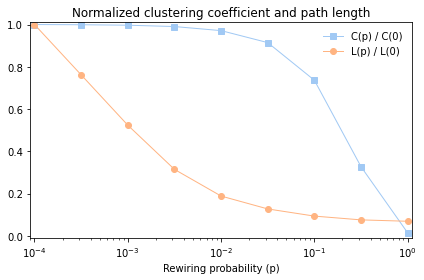

In [50]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

savefig('figs/chap03-3')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [51]:
lattice = make_ring_lattice(10, 4)

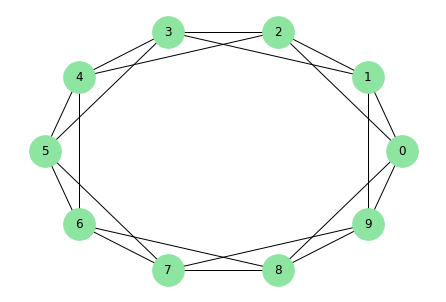

In [52]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [53]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [54]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [55]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [56]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [57]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [58]:
lattice = make_ring_lattice(10, 4)

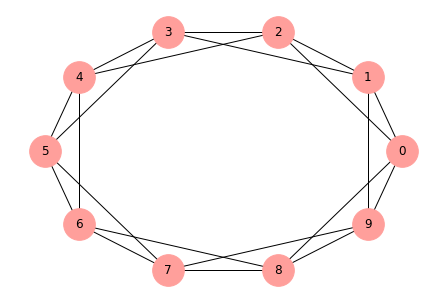

In [59]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [60]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

And here's the result from NetworkX:

In [61]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}

They are the same:

In [62]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [63]:
# Solution

lattice = make_ring_lattice(1000, 10)
d = shortest_path_dijkstra(lattice, 0)
for node, dist in d.items():
    print(node, dist)
    break

0 0


In [64]:
# Solution

func = lambda item: item[1]
node, dist = max(d.items(), key=func)
node, dist

(496, 100)

In [107]:
# # Solution

# d[495], d[496], d[497], d[498], d[499], d[500], d[501], d[502], d[503], d[504], d[505], 

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [65]:
# Here's `adjacent_edges` again for comparison:

def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [66]:
# Solution

# And here's a function that computes edges that connect each
# node to the one half-way around the circle

def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes."""
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v

In [67]:
# Solution

# Now we can make regular graphs.

def make_regular_graph(n, k):
    """Makes graph with `n` nodes where all nodes have `k` neighbors.
    
    Not possible if both `n` and `k` are odd.
    """
    # a is the number of adjacent edges
    # b is the number of opposite edges (0 or 1)
    a, b = divmod(k, 2)
    
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))
    
    # if k is odd, add opposite edges
    if b:
        if n%2:
            msg = "Can't make a regular graph if n and k are odd."
            raise ValueError(msg)
        G.add_edges_from(opposite_edges(nodes))
    return G

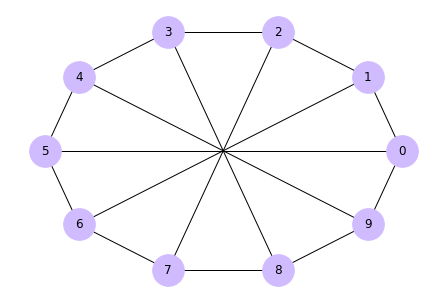

In [68]:
# Solution

# Here's an example.

regular = make_regular_graph(10, 3)

nx.draw_circular(regular, 
                 node_color='C4', 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [74]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [75]:
# Solution goes here

In [76]:
# Solution goes here

In [77]:
# Solution goes here

In [78]:
# Solution goes here

In [79]:
# Solution goes here

In [80]:
# Solution goes here

In [81]:
# Solution goes here

In [82]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [83]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [84]:
# Solution goes here

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [85]:
# Solution goes here

In [69]:
# This is about algorithmic complexity, not complexity science?!